# 微分方程式をディープラーニングで解く

解きたい微分方程式を
$$
u_t+{\mathcal N}[u]=0
$$
と表す。ここで$u(t, x)$は求めるべき解、${\mathcal N}[\bullet]$は空間微分などを含む演算子である。$x\in\Omega$は${\bf R}^d$上の部分空間を、$t\in[0,T]$は時間を表す。下付き文字は偏微分を表す。上式の右辺を
$$
f:=u_t+{\mathcal N}[u]
$$
と定義し、$u$をディープニューラルネットで近似することを考える。損失関数は二乗誤差
$$
MSE=MSE_u+MSE_f
$$
とする。ここで、
\begin{align}
MSE_u&=\frac{1}{N_u}\sum_{i=1}^{N_u}|u(t_u^i,x_u^i)-u^i|^2 \\
MSE_f&=\frac{1}{N_f}\sum_{i=1}^{N_f}|f(t_f^i,t_f^i)|^2
\end{align}
はそれぞれ拘束条件（初期条件や境界条件）に関する誤差、微分方程式そのものに関する誤差である。拘束条件が式で与えられている場合（時間反転対称性など）は、別途該当する二乗誤差の項を追加すればよい。$\{t_u^i,x_u^i,u_i\}_{i=1}^{N_u}$は拘束条件の訓練データ、$\{t _f^i,x _f^i\} _{i=1}^{N _f}$は微分方程式そのものに対する訓練データである。これを最小化することで微分方程式の近似解を得る。

# Burger's equation
Dirichlet境界条件下のBurger's equation
\begin{align}
&u_t+uu_x -(0.01/\pi)u_{xx}=0,\,x\in[-1,1],\,t\in[0,1]\\
&u(0,x)=-\sin(\pi x)\\
&u(t,-1)=u(t,1)=0
\end{align}

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import clear_output

In [2]:
class PlotLosses:
    def __init__(self):
        self.i = 0
        self.x = []
        self.losses = []
#         self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def update(self, loss, epoch=None, log=True):
#         self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(loss)
#         self.losses.append(logs.get('loss'))
#         self.val_losses.append(logs.get('val_loss'))
        if epoch is None:
            self.i += 1
        else:
            self.i = epoch
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
#         plt.plot(self.x, self.val_losses, label="val_loss")
        if log:
            plt.yscale("log")
        plt.legend()
        plt.show()

In [3]:
class Solver:
    def __init__(self, X_u, T_u, U, X_f, T_f, layers, d_eq):
        self.d_eq = d_eq
        
        X_u = np.expand_dims(X_u, axis=1)
        T_u = np.expand_dims(T_u, axis=1)
        X = np.concatenate([X_u, T_u], axis=1)
        
        self.X = X
        
        self.x_u = X[:,0:1]  # keep dim
        self.t_u = X[:,1:2]
        
        self.lb = X.min(axis=0)
        self.ub = X.max(axis=0)
        
        self.u = np.expand_dims(U, axis=1)
        
        self.x_f = np.expand_dims(X_f, axis=1)
        self.t_f = np.expand_dims(T_f, axis=1)
        
        # Initialize NN
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)  
        
        # tf Placeholders
        self.x_u_tf = tf.placeholder(tf.float32, shape=[None, self.x_u.shape[1]])
        self.t_u_tf = tf.placeholder(tf.float32, shape=[None, self.t_u.shape[1]])
        
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])
        
        # tf Graphs
        self.u_pred, _ = self.net(self.x_u_tf, self.t_u_tf)
        self.f_pred = self.net_f(self.x_f_tf, self.t_f_tf)
        
        # Loss
        self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_pred))
        
        # Optimizer
        self.count = 0
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
        
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
        self.plot_losses = PlotLosses()

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
    
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def net(self, x, t):
        X = tf.concat([x, t], axis=1)
        
        u = self.neural_net(X, self.weights, self.biases)
        u_x = tf.gradients(u, x)[0]

        return u, u_x

    def net_f(self, x, t):
        u, u_x = self.net(x, t)
        
        u_t = tf.gradients(u, t)[0]
        u_xx = tf.gradients(u_x, x)[0]
        
        return self.d_eq(u, u_t, u_x, u_xx)
    
    def callback(self, loss):
        if self.count % 100 == 0:
            elapsed = time.time() - self.start_time
            self.plot_losses.update(loss, self.nIter - 1 + self.count)
            print('L-BFGS-B It: %d, Loss: %.3e, Time: %.2f' % 
                  (self.count, loss, elapsed))
            self.start_time = time.time()
        self.count += 1
        
    def train(self, nIter):
        self.nIter = nIter
        tf_dict = {self.x_u_tf: self.x_u, self.t_u_tf: self.t_u,
                   self.u_tf: self.u,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 100 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                
                self.plot_losses.update(loss_value, it)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
                                                                                                                          
        self.start_time = time.time()
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)
        
    def predict(self, x, t):
        x = np.expand_dims(x, axis=1)
        t = np.expand_dims(t, axis=1)
        tf_dict = {self.x_u_tf: x, self.t_u_tf: t}
        
        u = self.sess.run(self.u_pred, tf_dict)
        
        return np.squeeze(u, axis=1)

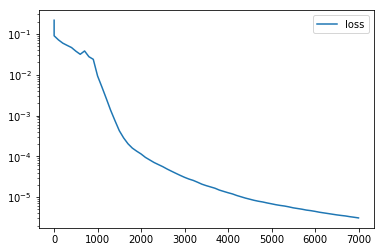

L-BFGS-B It: 6100, Loss: 3.092e-06, Time: 1.35
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.000003
  Number of iterations: 5606
  Number of functions evaluations: 6172


In [4]:
def burgers_eq(u, u_t, u_x, u_xx):
    return u_t + u * u_x - (0.01 / np.pi) * u_xx

N = 1000//2
x_ini = 2 * np.random.rand(N) - 1
x_u = np.concatenate([x_ini, (2 * np.random.randint(0, 2, N) - 1)])
t_u = np.concatenate([np.zeros(N), np.random.rand(N)])
u = np.concatenate([-np.sin(np.pi*x_ini), np.zeros(N)])

plt.scatter(x_u[:N], u[:N], s=1, alpha=0.5)
plt.show()

N = 10000
x_f = 2 * np.random.rand(N) - 1
t_f = np.random.rand(N)

plt.scatter(x_f, t_f, s=1, alpha=0.5)
plt.show()

layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
solver = Solver(x_u, t_u, u, x_f, t_f, layers, burgers_eq)
solver.train(1000)

0


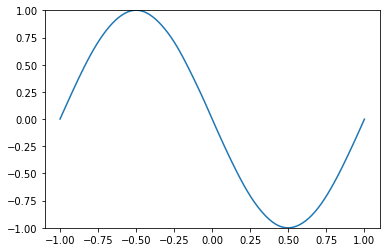

0.25


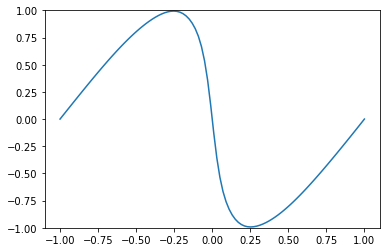

0.5


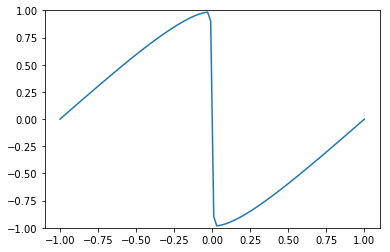

0.75


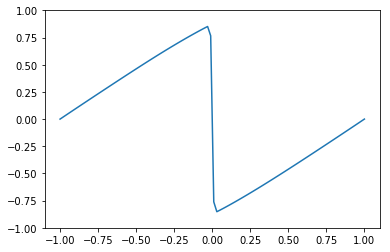

In [5]:
def plot(t):
    print(t)
    x = np.linspace(-1, 1, 100)
    t = t * np.ones(100)
    f = solver.predict(x, t)
    plt.plot(x, f)
    plt.ylim(-1, 1)
    plt.show()
    
plot(0)
plot(0.25)
plot(0.5)
plot(0.75)

# 1次元熱伝導方程式
\begin{align}
\frac{dT}{dt}-k&\frac{d^2T}{dx^2}=0 \nonumber\\
T(t,0)&=0\nonumber\\
T(t,1)&=1\nonumber\\
T(0,x)&=0.2,\ x\in[0.1, 0.9]\nonumber\\
\end{align}
- $k=0.001$
- $x\in(0,0.1)$, $x\in(0.9,1)$の初期条件は、微分方程式と整合性がとれるように自動的に決定される。
- 活性化関数にtanhを使う場合はアウトプットのスケールを[-1,1]の範囲に規格化。正の値になるならSigmoidやReLuを使ったほうが良い？

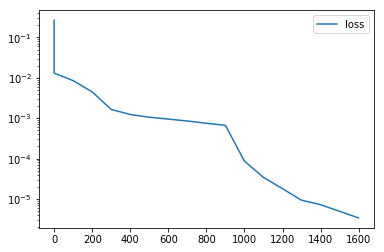

L-BFGS-B It: 700, Loss: 3.384e-06, Time: 1.49
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.000003
  Number of iterations: 704
  Number of functions evaluations: 767


In [6]:
def heat_transfer_eq(u, u_t, u_x, u_xx):
    k = 0.001
    return u_t - k * u_xx

N = 1000
x_b = np.random.randint(0, 2, N)
x_u = np.concatenate([0.1 + 0.8 * np.random.rand(N), x_b])
t_u = np.concatenate([np.zeros(N), 100 * np.random.rand(N)])
u = np.concatenate([0.25 * np.ones(N), x_b])

N = 10000
x_f = np.random.rand(N)
t_f = 100 * np.random.rand(N)

plt.scatter(x_f, t_f, s=1, alpha=0.5)
plt.show()

layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
solver = Solver(x_u, t_u, u, x_f, t_f, layers, heat_transfer_eq)
solver.train(1000)

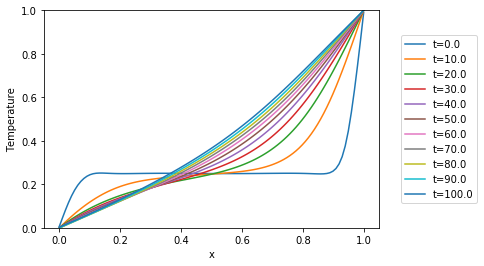

In [7]:
def plot(t):
    x = np.linspace(0, 1, 100)
    t = t * np.ones(100)
    f = solver.predict(x, t)
    plt.plot(x, f, label="t={}".format(t[0]))

for t in range(0, 101, 10):
    plot(t)
plt.ylim(0, 1)
plt.xlabel("x")
plt.ylabel("Temperature")
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.show()